In [ ]:
# Import neccessary libraries
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
# QR decomposition by gram-schmidt
def qr_decomposition(A):
    n, m = A.shape
    Q = np.zeros((n, m))
    R = np.zeros((m, m))
    for j in range(m):
        v = A[:, j]
        for i in range(j):
            R[i, j] = np.dot(Q[:, i], A[:, j])
            v = v - R[i, j] * Q[:, i]
        R[j, j] = np.linalg.norm(v)
        Q[:, j] = v / R[j, j]
    return Q, R

# apply qr decompoisiton iteratively to obtain eigenvalues and eigenvectors
def obtain_eig_by_qr(CtC, num_iter=1000, tol=1e-10):
    n = CtC.shape[0]
    Ak = CtC.copy()
    Q_total = np.eye(n)
    #1000 iteration for better result
    for _ in range(num_iter):
        Q, R = qr_decomposition(Ak)
        Ak = R @ Q  # @ is matrix multiplication
        Q_total = Q_total @ Q
        if np.allclose(Ak - np.diag(np.diag(Ak)), 0, atol=tol):
            break

    eigenvalues =np.diag(Ak)
    eigenvectors =Q_total
    idx =np.argsort(-np.abs(eigenvalues))
    eigenvalues=eigenvalues[idx]
    eigenvectors=eigenvectors[:, idx]
    for i in range(eigenvectors.shape[1]):
        if eigenvectors[0, i] < 0:
            eigenvectors[:, i] *=-1
    return eigenvalues, eigenvectors
    

In [ ]:
def SVD(C):
    """
    Singular Value Decomposition implementation.

    Given matrix C this function returns matrices U, Σ and V^T
        C ≈ U @ diag(Σ) @V^T
    Steps:
     Compute V from eigenvectors of (CᵀC)
     Compute Σ from square roots of eigenvalues
     Compute U from the formula Uᵢ = (C Vᵢ) / σᵢ
    """
    CtC = C.T @ C
    eigvals_V, V = obtain_eig_by_qr(CtC)

    singular_vals = np.sqrt(np.clip(eigvals_V, 0, None))
    U = np.zeros((C.shape[0], len(singular_vals)))

    for i in range(len(singular_vals)):
        if singular_vals[i] > 1e-10:
            U[:, i] = (C @ V[:, i]) / singular_vals[i]
        else:
            U[:, i] = 0

    return U, singular_vals, V.T


In [ ]:
# Apply Kabscha-Umeyama Algorithm to find R and t matrices
def kabsch(file1, file2, corres, mergedFileName):
    # read files
    mat1 =np.loadtxt(file1)
    mat2 =np.loadtxt(file2)
    #derive data from correspondences file
    correspondences =np.loadtxt(corres).astype(int)
    A_corr =mat1[correspondences[:, 0]]
    B_corr =mat2[correspondences[:, 1]]
    # calculate centroids
    A_centroid =A_corr.mean(axis=0)
    B_centroid =B_corr.mean(axis=0)
    A_centered = A_corr - A_centroid
    B_centered = B_corr - B_centroid
    #calculate covarience matrix H
    H =A_centered.T @ B_centered
    # we apply SVD to H to calculate R and t later
    U, S, Vt =SVD(H)

    R =Vt.T @ U.T  # we find Rotation matrix
    #we check if there is a reflection
    if np.linalg.det(R) < 0:
        Vt[-1, :] *=-1
        R =Vt.T@ U.T
    # calculate translation vector
    t = B_centroid -R @A_centroid
    mat1_transformed =(R @ mat1.T).T + t # do rotation, translation to mat1
    merged =np.vstack((mat1_transformed, mat2)) # merge 2 data files
    np.savetxt(mergedFileName, merged, fmt="%.6f")
    return R, t, mat1, mat2, mat1_transformed

In [ ]:
def plotObject(objectName):
  R, t, mat1, mat2, mat1_aligned = kabsch(
      f"{objectName}/mat1.txt",
      f"{objectName}/mat2.txt",
      f"{objectName}/correspondences.txt",
      f"merged{objectName}.xyz")
  print("Rotation Matrix R:\n", R)
  print("Translation Vector t:\n", t)

  # Plot before and after alignment
  fig = plt.figure(figsize=(12, 5))
  ax1 = fig.add_subplot(121, projection='3d')
  ax1.scatter(mat1[:, 0], mat1[:, 1], mat1[:, 2], c='r', label='mat1')
  ax1.scatter(mat2[:, 0], mat2[:, 1], mat2[:, 2], c='b', label='mat2')
  ax1.set_title("Before Alignment")
  ax1.legend()

  ax2 = fig.add_subplot(122, projection='3d')
  ax2.scatter(mat1_aligned[:, 0], mat1_aligned[:, 1], mat1_aligned[:, 2], c='r', label='mat1 aligned')
  ax2.scatter(mat2[:, 0], mat2[:, 1], mat2[:, 2], c='b', label='mat2')
  ax2.set_title("After Alignment")
  ax2.legend()
  plt.savefig("alignment_result.png", dpi=300)
  plt.show()

Rotation Matrix R:
 [[-0.10160929 -0.49427978 -0.86334411]
 [-0.00591879  0.8681207  -0.49631786]
 [ 0.99480677 -0.04532055 -0.09113467]]
Translation Vector t:
 [1.51082729 1.89294346 1.89629477]


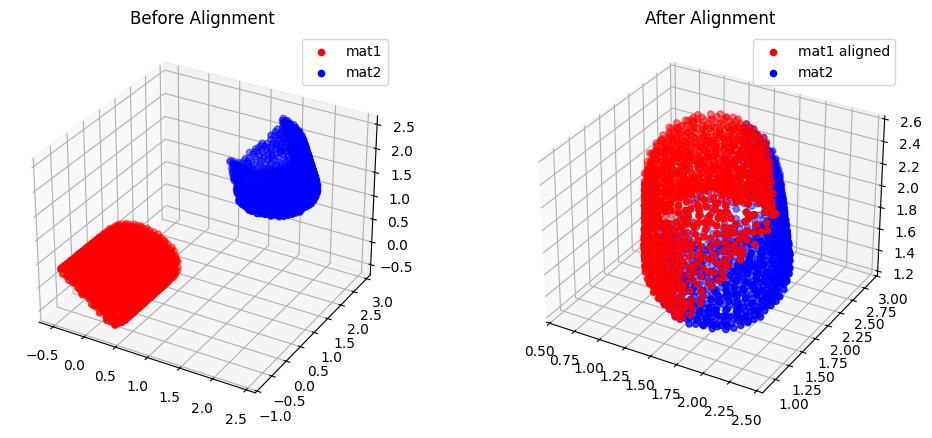

In [ ]:
# Plot the cup
plotObject("cup")

Rotation Matrix R:
 [[ 0.12801764 -0.14736851 -0.98076195]
 [-0.45352553 -0.88814468  0.07425379]
 [-0.88200118  0.43529479 -0.18053357]]
Translation Vector t:
 [1.43531892 1.42036429 1.33033964]


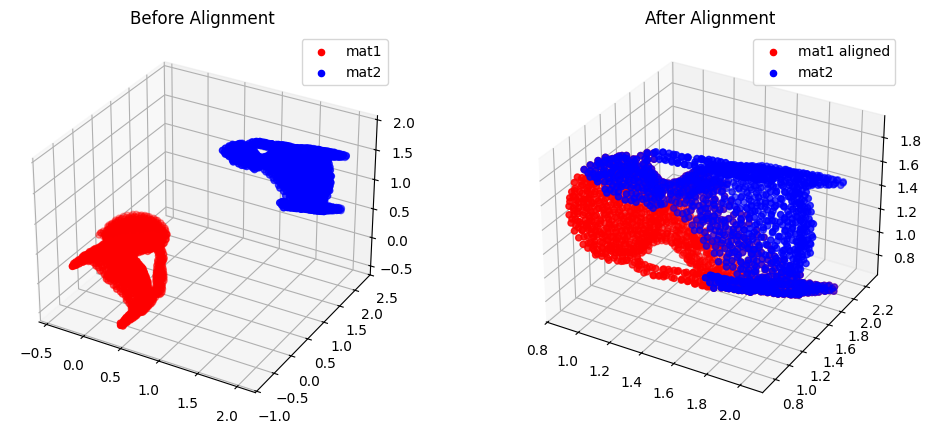

In [ ]:
# plot the chair
plotObject("chair")

Rotation Matrix R:
 [[-0.7468572  -0.38868106  0.5395659 ]
 [-0.56646154 -0.05314962 -0.82237245]
 [ 0.34831832 -0.91983811 -0.1804777 ]]
Translation Vector t:
 [1.53086172 1.23273344 1.01140052]


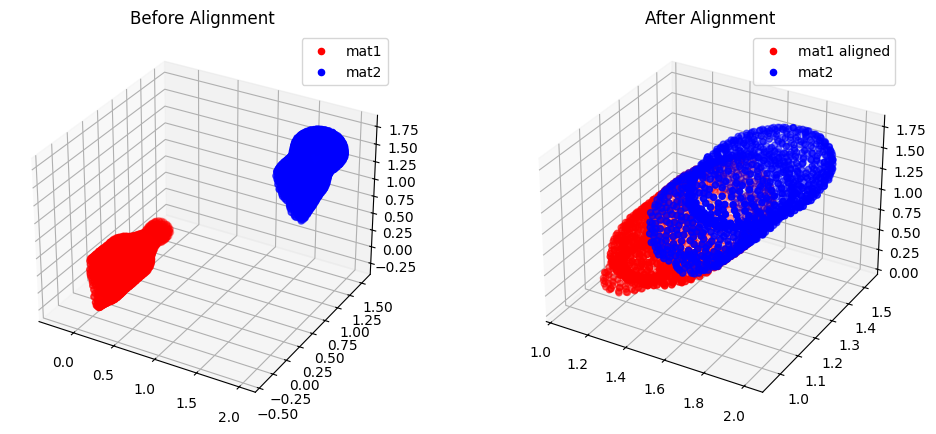

In [ ]:
#plot the bottle
plotObject("bottle")